In [17]:
import pandas as pd
import torch
from glob import glob
import os

from config import ROOT_DIR

In [118]:
base_path = os.path.join(ROOT_DIR, '.rawdata', 'acorn_sat')

sites = pd.read_csv(os.path.join(base_path, 'acorn_sat_sites.csv'), dtype={'stn_num': 'Int64'})
sites.describe()

,stn_num,lat,lon,elevation,start
count,112.0,112.000000,112.000000,112.000000,112.000000
mean,40599.419643,-29.541339,139.139107,164.723214,1924.491071
std,28246.557901,7.435009,11.933751,205.079471,19.716457
min,1019.0,-43.490000,113.670000,2.000000,1910.000000
25%,15476.25,-34.932500,133.027500,22.250000,1910.000000
50%,36520.5,-30.940000,143.520000,97.500000,1910.000000
75%,63521.25,-24.617500,148.357500,237.500000,1941.250000
max,96003.0,-10.580000,153.470000,1482.000000,1975.000000


In [110]:
folder_path = os.path.join(base_path, 'max_temp')
files = glob(os.path.join(folder_path, '*.csv'))
station_yearly_averages=[]
for file in files:
    df = pd.read_csv(file, dtype={'site number': 'Int64'})
    df = df.rename(columns={'maximum temperature (degC)': 'max'})
    
    site_number = df.iloc[0]['site number']
    site_details = sites[sites['stn_num'] == site_number]
    
    df = df.iloc[1:].reset_index(drop=True)
    df['date'] = pd.to_datetime(df['date'])
    df['year'] = df['date'].dt.year

    df = df[df['max'].notna()]
    
    yearly_avg = df.groupby('year')['max'].max().reset_index()
    yearly_avg['stn_num'] = site_details.iloc[0]['stn_num']
    yearly_avg['lat'] = site_details.iloc[0]['lat']
    yearly_avg['lon'] = site_details.iloc[0]['lon']
    yearly_avg['elevation'] = site_details.iloc[0]['elevation']
    station_yearly_averages.append(yearly_avg)

final_df = pd.concat(station_yearly_averages)
start_year = final_df['year'].min()
final_df['years_since_start'] = final_df['year'] - start_year

In [111]:
# Optional filtering and dataset stats
#final_df = final_df.query('lat > -38 & lat < -28')
#final_df = final_df.query('elevation < 1000')

min_elevation = final_df['elevation'].min()
max_elevation = final_df['elevation'].max()
num_sites = final_df['stn_num'].nunique()
print(f"Filtered to data from {num_sites} sites, elevation ranging from {min_elevation} to {max_elevation}")

Filtered to data from 112 sites, elevation ranging from 2 to 1482


tensor(False) tensor(False)
tensor(False) tensor(False)
x_mean: 61.89704895019531, y_mean: 40.25794219970703, x_std: 31.51657485961914, y_std: 4.521125793457031
Epoch 0, Loss: 1.2760342359542847
Epoch 10, Loss: 0.9953565001487732
Epoch 20, Loss: 0.9920182228088379
Epoch 30, Loss: 0.9919798374176025
Epoch 40, Loss: 0.9919793605804443
Epoch 50, Loss: 0.9919793605804443
Epoch 60, Loss: 0.9919793605804443
Epoch 70, Loss: 0.9919793009757996
Epoch 80, Loss: 0.9919793009757996
Epoch 90, Loss: 0.9919793009757996
Predicted max temperature for 2150: 42.53°C
Predicted temperature range between 33.49°C to 51.58°C


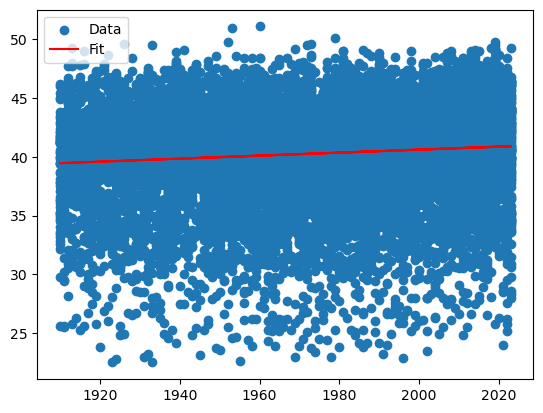

In [117]:
import torch.nn as nn

x = torch.tensor(final_df['years_since_start'].values, dtype=torch.float32).unsqueeze(1)
y = torch.tensor(final_df['max'].values, dtype=torch.float32).unsqueeze(1)

# Check for nan values
print(torch.isnan(x).any(), torch.isinf(x).any())
print(torch.isnan(y).any(), torch.isinf(y).any())

# Standardise tensors
x_mean = x.mean()
y_mean = y.mean()
x_std = x.std()
y_std = y.std()
print(f"x_mean: {x_mean}, y_mean: {y_mean}, x_std: {x_std}, y_std: {y_std}")

x_train = (x - x.mean()) / x.std()
y_train = (y - y.mean()) / y.std()

model = nn.Linear(in_features=1, out_features=1)
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

for epoch in range(100):
    y_pred = model(x_train)
    loss = criterion(y_pred, y_train)

    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}")
    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()

# New input year
new_year = 2150
years_since_start = new_year - start_year
x_new = torch.tensor([[years_since_start]], dtype=torch.float32)
x_new_standardized = (x_new - x_mean) / x_std

# Prediction of temperature at new year
y_pred_standardized = model(x_new_standardized)
y_pred = y_pred_standardized * y_std + y_mean

print(f"Predicted max temperature for {new_year}: {y_pred.item():.2f}°C")

likely_max = y_pred.item() + (y_std * 2)
likely_min = y_pred.item() - (y_std * 2)
print(f"Predicted temperature range between {likely_min:.2f}°C to {likely_max:.2f}°C")

plt.scatter((x + start_year).numpy(), y.numpy(), label="Data")

predicted_line = model(x_train).detach() * y_std + y_mean
plt.plot((x + start_year).numpy(), predicted_line.numpy(), color="red", label="Fit")
plt.legend()
plt.show()